In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)

In [2]:
# 변수 지정
df_cats = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')
df_train = pd.read_csv('sales_train.csv')
df_shops = pd.read_csv('shops.csv')
df_test = pd.read_csv('test.csv')

#### 데이터 전반적인 checking

In [3]:
print('------------- train info ------------') ; print(df_train.info(), '\n')
print('------------- test info ------------') ; print(df_test.info(), '\n')
print('------------- items info ------------') ; print(df_items.info(), '\n')
print('------------- shops info ------------') ; print(df_shops.info(), '\n')
print('------------- categories info ------------') ; print(df_cats.info(), '\n')

------------- train info ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None 

------------- test info ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None 

------------- items info ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            N

#### null 값 확인

In [4]:
print(df_train.isnull().sum(), '\n')
print(df_test.isnull().sum(), '\n')
print(df_items.isnull().sum(), '\n')
print(df_shops.isnull().sum(), '\n')
print(df_cats.isnull().sum(), '\n')
# nan 값 없음.

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64 

ID         0
shop_id    0
item_id    0
dtype: int64 

item_name           0
item_id             0
item_category_id    0
dtype: int64 

shop_name    0
shop_id      0
dtype: int64 

item_category_name    0
item_category_id      0
dtype: int64 



#### 이상치 확인

In [5]:
df_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

<AxesSubplot:xlabel='item_price'>

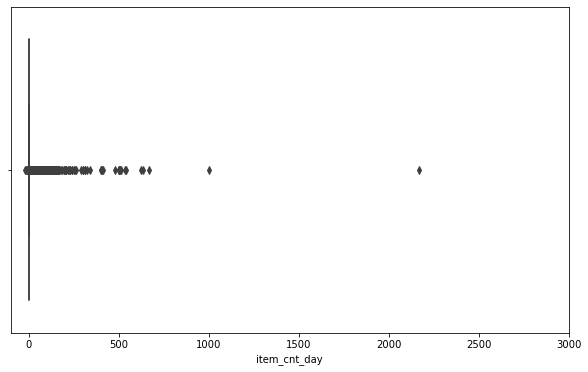

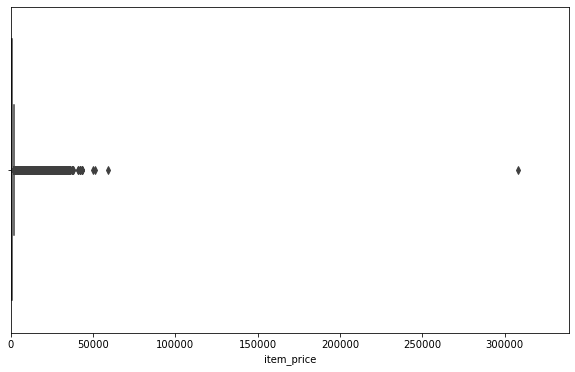

In [6]:
plt.figure(figsize=(10,6))
plt.xlim(-100, 3000)
sns.boxplot(x=df_train.item_cnt_day)

plt.figure(figsize=(10,6))
plt.xlim(df_train.item_price.min(), df_train.item_price.max()*1.1)
sns.boxplot(x=df_train.item_price)

In [7]:
print(len(df_train[df_train.item_cnt_day>999]))
print(len(df_train[df_train.item_cnt_day>500]))
print(len(df_train[df_train.item_cnt_day<=500]))

2
12
2935837


In [8]:
df_train = df_train[df_train.item_price<100000]
df_train = df_train[df_train.item_cnt_day<1000]

<AxesSubplot:xlabel='item_price'>

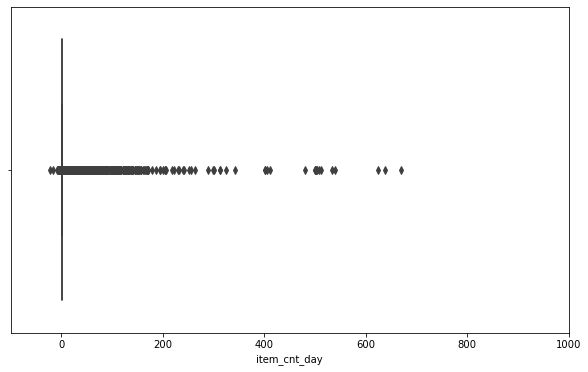

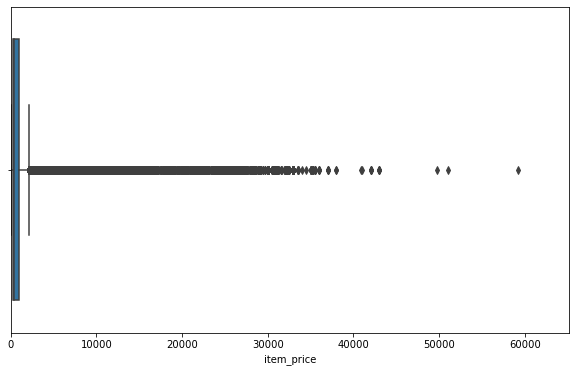

In [9]:
plt.figure(figsize=(10,6))
plt.xlim(-100, 1000)
sns.boxplot(x=df_train.item_cnt_day)

plt.figure(figsize=(10,6))
plt.xlim(df_train.item_price.min(), df_train.item_price.max()*1.1)
sns.boxplot(x=df_train.item_price)

In [10]:
# 이상치가 제거된 것을 확인.
# 음수 값의 존재를 확인 >>> 0으로 변환.

In [11]:
df_train = df_train[df_train.item_price > 0].reset_index(drop=True)
df_train[df_train.item_cnt_day <= 0].item_cnt_day.unique()
df_train.loc[df_train.item_cnt_day < 1, 'item_cnt_day'] = 0

In [12]:
df_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00           0.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [13]:
df_train[df_train.duplicated() == True]

date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435365  23.02.2014              13       50     3423       999.0   
1496764  23.03.2014              14       21     3423       999.0   
1671871  01.05.2014              16       50     3423       999.0   
1866338  12.07.2014              18       25     3423       999.0   
2198564  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435365           1.0  
1496764           1.0  
1671871           1.0  
1866338           1.0  
2198564           1.0

In [14]:
# df_shop에서 shop_name을 잘 살펴보면, 0과 57, 1과 58, 10과 11, 39와 40이 겹치는 것을 알 수 있다.

In [15]:
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57

df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58

df_train.loc[df_train.shop_id == 11, 'shop_id'] = 10
df_test.loc[df_test.shop_id == 11, 'shop_id'] = 10

df_train.loc[df_train.shop_id == 40, 'shop_id'] = 39
df_test.loc[df_test.shop_id == 40, 'shop_id'] = 39

In [16]:
# len(set(df_train.shop_id.value_counts()) - set(df_test.shop_id.value_counts()))

#### Shops dataset preprocessing

In [17]:
# df_shops

In [18]:
df_shops.shop_name.unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [19]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops['category'] = df_shops['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
df_shops.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [20]:
df_shops.groupby(['category']).sum()

shop_id
category              
etc                 68
Магазин             22
Орджоникидзе,       57
ТК                 184
ТРК                140
ТРЦ                340
ТЦ                 883
склад               55
ул.                 21

In [21]:
# value가 작은 category는 etc로 통합

In [22]:
category = ['ТК', 'ТРК', 'ТРЦ', 'ТЦ']
df_shops.category = df_shops.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', df_shops.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [23]:
df_shops.head(3)

shop_name  shop_id    city category
0  !Якутск Орджоникидзе, 56 фран        0  Якутск      etc
1  !Якутск ТЦ "Центральный" фран        1  Якутск       ТЦ
2               Адыгея ТЦ "Мега"        2  Адыгея       ТЦ

In [24]:
df_shops['shop_city'] = df_shops.city
df_shops['shop_category'] = df_shops.category

df_shops['shop_city'] = LabelEncoder().fit_transform(df_shops['shop_city'])
df_shops['shop_category'] = LabelEncoder().fit_transform(df_shops['shop_category'])

df_shops = df_shops[['shop_id','shop_city','shop_category']]
df_shops.head()

shop_id  shop_city  shop_category
0        0         29              0
1        1         29              4
2        2          0              4
3        3          1              2
4        4          2              4

#### Category dataset preprocessing

In [25]:
df_cats.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [26]:
print(len(df_cats.item_category_name.unique()))
df_cats.item_category_name.unique()

84


array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

In [27]:
df_cats['type_code'] = df_cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
df_cats.loc[(df_cats.type_code == 'Игровые') | (df_cats.type_code == 'Аксессуары'), 'category'] = 'Игры'
df_cats.loc[df_cats.type_code == 'PC', 'category'] = 'Музыка'

In [28]:
category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

In [29]:
df_cats['type_code'] = df_cats.type_code.apply(lambda x: x if (x in category) else 'etc')

In [30]:
print(df_cats.groupby(['type_code']).sum())

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [31]:
df_cats['type_code'] = LabelEncoder().fit_transform(df_cats['type_code'])
df_cats.head()

item_category_name  item_category_id  type_code category
0  PC - Гарнитуры/Наушники                 0          0   Музыка
1         Аксессуары - PS2                 1          0     Игры
2         Аксессуары - PS3                 2          0     Игры
3         Аксессуары - PS4                 3          0     Игры
4         Аксессуары - PSP                 4          0     Игры

In [32]:
df_cats['split'] = df_cats.item_category_name.apply(lambda x: x.split('-'))
df_cats['subtype'] = df_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_cats['subtype_code'] = LabelEncoder().fit_transform(df_cats['subtype'])
df_cats = df_cats[['item_category_id', 'type_code', 'subtype_code']]

In [33]:
df_cats.head()

item_category_id  type_code  subtype_code
0                 0          0            29
1                 1          0             9
2                 2          0            10
3                 3          0            11
4                 4          0            13

#### Category dataset preprocessing

In [34]:
import re
from collections import Counter
from operator import itemgetter

df_items['name_1'], df_items['name_2'] = df_items['item_name'].str.split('[', 1).str
df_items['name_1'], df_items['name_3'] = df_items['item_name'].str.split('(', 1).str

df_items['name_2'] = df_items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items['name_3'] = df_items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
df_items = df_items.fillna('0')

result_1 = Counter(' '.join(df_items['name_2'].values.tolist()).split(' ')).items() # 키와 값들의 쌍을 얻을 수 있는 함수
result_1 = sorted(result_1, key=itemgetter(1)) # itemgetter(1) 0이면 key, 1이면 value 로 정렬
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)] # 논의사항1

result_2 = Counter(' '.join(df_items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

C:\Users\광운MOOC센터\AppData\Local\Temp\ipykernel_30384\3327090601.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_items['name_1'], df_items['name_2'] = df_items['item_name'].str.split('[', 1).str
C:\Users\광운MOOC센터\AppData\Local\Temp\ipykernel_30384\3327090601.py:6: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_items['name_1'], df_items['name_3'] = df_items['item_name'].str.split('(', 1).str
C:\Users\광운MOOC센터\AppData\Local\Temp\ipykernel_30384\3327090601.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_items['name_2'] = df_items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
C:\Users\광운MOOC센터\AppData\Local\Temp\ipykernel_30384\3327090601.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_items['name_3'] = df_items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [35]:
df_items['type'] = df_items.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
df_items['type'].unique()

array(['0', 'pc', 'ps3', 'pс', 'xbox 360', 'цифровая', '', 'p', 'mac',
       'psp', 'рs3', 'ps4', 'xbox one', 'x360', 'ps', 'xbox360',
       'русская', 'рс', 'android', 'англ', 'ps2', 'только', 'цифров',
       '6jv', 'j72', 'hm3', 's3v', '6dv', '6l6', '5f4', 's4v', 'kg4',
       '5c5', '5c7', 'kf7', 'kf6'], dtype=object)

In [36]:
df_items.loc[(df_items.type == 'x360') | (df_items.type == 'xbox360'), 'type'] = 'xbox 360'
df_items.loc[df_items.type == '', 'type'] = 'mac'
df_items.type = df_items.type.apply(lambda x: x.replace(' ',''))
df_items.loc[(df_items.type == 'pc')|(df_items.type == 'pс')|(df_items.type == 'рс'), 'type'] = 'pc'
df_items.loc[(df_items.type == 'рs3'), 'type'] = 'ps3'

In [37]:
df_items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                                             name_1  \
0                40                            ! ВО ВЛАСТИ НАВАЖДЕНИЯ    
1                76  !ABBYY FineReader 12 Professional Edition Full...   
2                40                                ***В ЛУЧАХ СЛАВЫ      
3                40                                 ***ГОЛУБАЯ ВОЛНА     
4                40                                        ***КОРОБКА    

                name_2    name_3 type  
0                    0   пласт d    0  
1  pc цифровая версия          0   pc  
2                    0     unv d    0  
3                    0    univ d    0  
4                    0  стекло d    0

In [38]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
 3   name_1            22170 non-null  object
 4   name_2            22170 non-null  object
 5   name_3            22170 non-null  object
 6   type              22170 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.2+ MB


In [39]:
group_sum = df_items.groupby('type').sum()
group_sum.head()

item_id  item_category_id
type                             
0     218310960            872182
5c5       12118                16
5c7       26808                32
5f4        7936                 7
6dv        7934                 7

In [40]:
group_sum.loc[group_sum.item_category_id < 200]

item_id  item_category_id
type                              
5c5        12118                16
5c7        26808                32
5f4         7936                 7
6dv         7934                 7
6jv         7924                 7
6l6         7935                 7
android    12994                78
hm3         7926                 7
j72        31709                28
kf6        13403                16
kf7        13402                16
kg4        12117                16
p            721                78
ps2         7076                36
s3v         7933                 7
s4v         7937                 7
англ        2821                28
русская     1547                25
только     60074               156
цифров      3864                54

In [41]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

df_items.name_2 = df_items.type.apply(lambda x: 'etc' if x in drop_list else x)
df_items = df_items.drop(['type'], axis=1)
df_items.groupby('name_2').sum()

item_id  item_category_id
name_2                               
0         218310960            872182
etc          249594               496
mac          148022              2245
p               721                78
pc         16991083            106924
ps           431537              1738
ps3         3531772             11422
ps4          895981              3489
psp          692947              2415
xbox360     2362398             10718
xboxone      566890              2952
цифров         3864                54
цифровая    1557596             11553

In [42]:
df_items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                                             name_1 name_2  \
0                40                            ! ВО ВЛАСТИ НАВАЖДЕНИЯ       0   
1                76  !ABBYY FineReader 12 Professional Edition Full...     pc   
2                40                                ***В ЛУЧАХ СЛАВЫ         0   
3                40                                 ***ГОЛУБАЯ ВОЛНА        0   
4                40                                        ***КОРОБКА       0   

     name_3  
0   пласт d  
1         0  
2     unv d  
3    univ d  
4  стекло d

In [43]:
df_items['name_2'] = LabelEncoder().fit_transform(df_items['name_2'])
df_items['name_3'] = LabelEncoder().fit_transform(df_items['name_3'])
df_items.drop(['item_name','name_1'], axis=1, inplace=True)
df_items.head()

item_id  item_category_id  name_2  name_3
0        0                40       0    1331
1        1                76       4      42
2        2                40       0    1011
3        3                40       0    1010
4        4                40       0    1572

In [44]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    # 이 메소드의 특징은 두 개 이상의 리스트의 모든 조합을 구할 때 사용된다.
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# vstack : 배열과 배열의 결합. 세로로 결합. 무조건 열의 개수는 맞아야 결합이 성사.
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
# default = ascending

In [45]:
print(matrix)
df_train.head()

          date_block_num  shop_id  item_id
114910                 0        2       19
117150                 0        2       27
120623                 0        2       28
118316                 0        2       29
114602                 0        2       32
...                  ...      ...      ...
10697061              33       59    22162
10697251              33       59    22163
10697917              33       59    22164
10699443              33       59    22166
10698738              33       59    22167

[10842077 rows x 3 columns]


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00           0.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [46]:
df_train['revenue'] = df_train['item_price']*df_train['item_cnt_day']

In [47]:
dff_train = df_train.copy()

In [48]:
dff_train["date"] = pd.to_datetime(df_train["date"], format = "%d.%m.%Y")
dff_train.set_index('date').head()

date_block_num  shop_id  item_id  item_price  item_cnt_day  \
date                                                                     
2013-01-02               0       59    22154      999.00           1.0   
2013-01-03               0       25     2552      899.00           1.0   
2013-01-05               0       25     2552      899.00           0.0   
2013-01-06               0       25     2554     1709.05           1.0   
2013-01-15               0       25     2555     1099.00           1.0   

            revenue  
date                 
2013-01-02   999.00  
2013-01-03   899.00  
2013-01-05     0.00  
2013-01-06  1709.05  
2013-01-15  1099.00

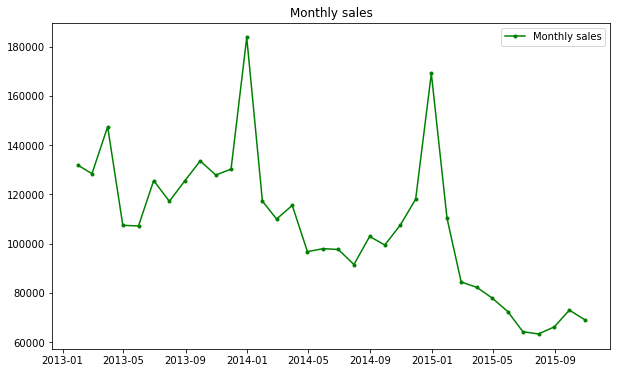

In [49]:
ts_M = dff_train[["date", "item_cnt_day"]].set_index("date").resample("M").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_M, color = "Green", label = "Monthly sales",marker='.')
plt.title("Monthly sales")
plt.legend();

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


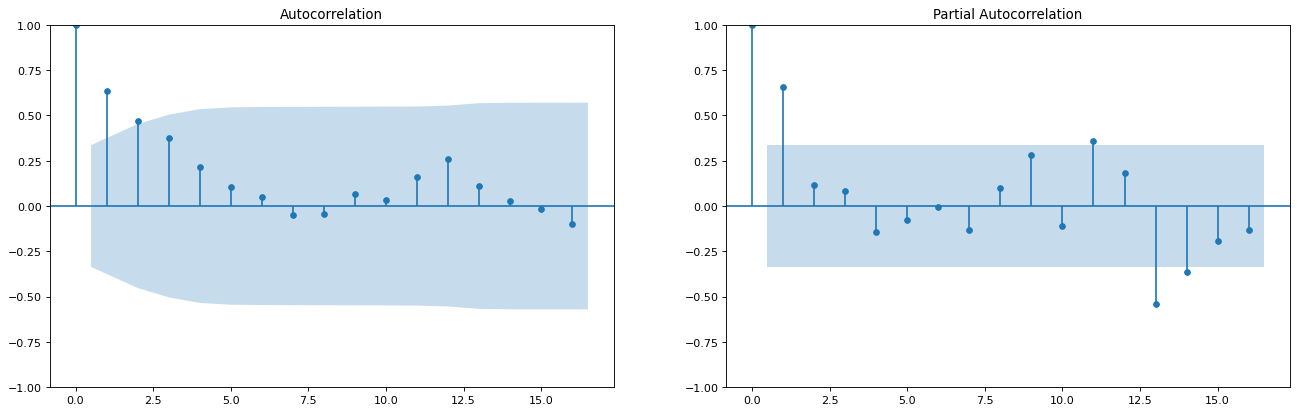

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,6), dpi = 80)
plot_acf(ts_M, ax = ax1, lags = 16)
plot_pacf(ts_M, ax = ax2, lags = 16);

In [51]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [52]:
group.head(2)

date_block_num  shop_id  item_id  item_cnt_month
0               0        2       27             1.0
1               0        2       33             1.0

In [53]:
matrix.head(2)

date_block_num  shop_id  item_id
114910               0        2       19
117150               0        2       27

In [54]:
matrix = pd.merge(matrix, group, on=cols, how='left')

In [55]:
matrix.head(1)

date_block_num  shop_id  item_id  item_cnt_month
0               0        2       19             NaN

In [56]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0) # astype(np.float16))
                                                    .clip(0,20) 
                                    # clip(array,min,max) # min보다 작은 값은 min으로, max보다 큰 값은 max로 치환.
                                                    .astype(np.float16))

#### Test set

In [57]:
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num'].astype(np.int8)
df_test['shop_id'] = df_test['shop_id'].astype(np.int8)
df_test['item_id'] = df_test['item_id'].astype(np.int16)

In [58]:
matrix.head(2)

date_block_num  shop_id  item_id  item_cnt_month
0               0        2       19             0.0
1               0        2       27             1.0

In [59]:
df_test.head(2)

ID  shop_id  item_id  date_block_num
0   0        5     5037              34
1   1        5     5320              34

In [60]:
matrix = pd.concat([matrix, df_test], ignore_index=True, sort=False, keys=cols)
matrix.head(3)

date_block_num  shop_id  item_id  item_cnt_month  ID
0               0        2       19             0.0 NaN
1               0        2       27             1.0 NaN
2               0        2       28             0.0 NaN

In [61]:
matrix.fillna(0, inplace=True)  # 34 month

In [62]:
matrix = pd.merge(matrix, df_shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, df_items, on=['item_id'], how='left')
matrix = pd.merge(matrix, df_cats, on=['item_category_id'], how='left')

In [63]:
matrix.head(3)

date_block_num  shop_id  item_id  item_cnt_month   ID  shop_city  \
0               0        2       19             0.0  0.0          0   
1               0        2       27             1.0  0.0          0   
2               0        2       28             0.0  0.0          0   

   shop_category  item_category_id  name_2  name_3  type_code  subtype_code  
0              4                40       0      42          3             4  
1              4                19       6      42          1            10  
2              4                30       4      42          1            55

In [64]:
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

#### Target lags

In [65]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()  # for문 안에서 돌 때마다 새로운 copy를 찍어내기 때문에 누적합(+=i)이 되지 않음.
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [66]:
martrix = lag_feature(matrix, [1,2,3], 'item_cnt_month')

In [67]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month   ID  shop_city  \
0               0        2       19             0.0  0.0          0   
1               0        2       27             1.0  0.0          0   
2               0        2       28             0.0  0.0          0   
3               0        2       29             0.0  0.0          0   
4               0        2       32             0.0  0.0          0   

   shop_category  item_category_id  name_2  name_3  type_code  subtype_code  
0              4                40       0      42          3             4  
1              4                19       6      42          1            10  
2              4                30       4      42          1            55  
3              4                23       9      42          1            16  
4              4                40       0      42          3             4

#### Mean encoded features

###### 평균에 관한 lags를 생성합니다.
##### feature은 결국, train data로 사용하기 위한 columns
##### feature : 학습 및 예측을 할 데이터의 특징, 항목 들을 의미한다.

In [68]:
# 월별 매출량 평균 merge
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

In [69]:
matrix = pd.merge(matrix,group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [70]:
matrix.head(3)

date_block_num  shop_id  item_id  item_cnt_month   ID  shop_city  \
0               0        2       19             0.0  0.0          0   
1               0        2       27             1.0  0.0          0   
2               0        2       28             0.0  0.0          0   

   shop_category  item_category_id  name_2  name_3  type_code  subtype_code  \
0              4                40       0      42          3             4   
1              4                19       6      42          1            10   
2              4                30       4      42          1            55   

   date_avg_item_cnt_lag_1  
0                      NaN  
1                      NaN  
2                      NaN

In [71]:
# 월별 item_id별 매출량 평균 merge
group = matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

In [72]:
matrix = pd.merge(matrix,group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [73]:
# 월별 shop_id별 매출량 평균
group = matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [74]:
matrix.head()

date_block_num  shop_id  item_id  item_cnt_month   ID  shop_city  \
0               0        2       19             0.0  0.0          0   
1               0        2       27             1.0  0.0          0   
2               0        2       28             0.0  0.0          0   
3               0        2       29             0.0  0.0          0   
4               0        2       32             0.0  0.0          0   

   shop_category  item_category_id  name_2  name_3  type_code  subtype_code  \
0              4                40       0      42          3             4   
1              4                19       6      42          1            10   
2              4                30       4      42          1            55   
3              4                23       9      42          1            16   
4              4                40       0      42          3             4   

   date_avg_item_cnt_lag_1  date_item_avg_item_cnt_lag_1  \
0                      NaN                           NaN   
1                      NaN                           NaN   
2                      NaN                           NaN   
3                      NaN                           NaN   
4                      NaN                           NaN   

   date_item_avg_item_cnt_lag_2  date_item_avg_item_cnt_lag_3  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_1  date_shop_avg_item_cnt_lag_2  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_3  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN

In [75]:
# 월별 category_id별 매출량 평균
group = matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

In [76]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_cat_avg_item_cnt')
# 캐글에서는 lag1만 생성하는데, 이유를 모르겠어서 저는 lag1 lag2 lag3을 생성하겠습니다.
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [77]:
# 월별 shop_id별 item_cat_id별 매출량 평균
group = matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

In [78]:
matrix = pd.merge(matrix,group, on=['date_block_num','shop_id','item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [79]:
# 월별, shop_id별 item_id별 매출량 평균
group = matrix.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_item_avg_item_cnt']
group.reset_index(inplace=True)

In [80]:
matrix = pd.merge(matrix,group, on=['date_block_num','shop_id','item_id'], how='left')
matrix['date_shop_item_avg_item_cnt'] = matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_item_avg_item_cnt')
matrix.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)

In [81]:
# 월별, shop_id, subtype_code별 매출량 평균
group = matrix.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['date_block_num','shop_id','subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [82]:
# 월별 shop_city별 매출량 평균
group = matrix.groupby(['date_block_num','shop_city']).agg({'item_cnt_month':['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['date_block_num','shop_city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [83]:
# 월별 item_id별 shop_city별 매출량 평균
group = matrix.groupby(['date_block_num','item_id','shop_city']).agg({'item_cnt_month':['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['date_block_num','item_id','shop_city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [84]:
# 월별 type_code별 매출 평균
# group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_type_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
# matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
# matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [85]:
# 월별 subtype_code별 매출량 평균
# group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_subtype_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
# matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
# matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

#### Trend Features

In [86]:
# 가격을 중심으로.
df_train.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154       999.0           1.0   
1  03.01.2013               0       25     2552       899.0           1.0   
2  05.01.2013               0       25     2552       899.0           0.0   

   revenue  
0    999.0  
1    899.0  
2      0.0

In [87]:
# item_id별 
group = df_train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = df_train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix,group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [88]:
# 몇 퍼 증가, 혹은 몇 퍼 하락했는지 알기 위해 >>> 추세
lags = [1,2,3]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [89]:
group = df_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [90]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [91]:
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num       

In [92]:
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num         

In [93]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [114]:
matrix.head(3)

NameError: name 'matrix' is not defined

In [95]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Data columns (total 43 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   shop_city                             int8   
 6   shop_category                         int8   
 7   item_category_id                      int8   
 8   name_2                                int32  
 9   name_3                                int32  
 10  type_code                             int8   
 11  subtype_code                          int8   
 12  date_avg_item_cnt_lag_1               float16
 13  date_item_avg_item_cnt_lag_1          float16
 14  date_item_avg_item_cnt_lag_2          float16
 15  date_item_avg

In [96]:
# matrix.drop(['date_item_avg_item_price_lag_1_y','date_item_avg_item_price_lag_2_y','date_item_avg_item_price_lag_3_y'], axis=1, inplace=True)

In [97]:
# matrix.rename(columns = {'date_item_avg_item_price_lag_1_x':'date_item_avg_item_price_lag_1'}, inplace=True)
# matrix.rename(columns = {'date_item_avg_item_price_lag_2_x':'date_item_avg_item_price_lag_2'}, inplace=True)
# matrix.rename(columns = {'date_item_avg_item_price_lag_3_x':'date_item_avg_item_price_lag_3'}, inplace=True)

In [98]:
# matrix.drop(['delta_revenue_lag_1_y'], axis=1, inplace=True)
# matrix.rename(columns = {'delta_revenue_lag_1_x':'delta_revenue_lag_1'}, inplace=True)

In [99]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056277 entries, 0 to 11056276
Data columns (total 43 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   shop_city                             int8   
 6   shop_category                         int8   
 7   item_category_id                      int8   
 8   name_2                                int32  
 9   name_3                                int32  
 10  type_code                             int8   
 11  subtype_code                          int8   
 12  date_avg_item_cnt_lag_1               float16
 13  date_item_avg_item_cnt_lag_1          float16
 14  date_item_avg_item_cnt_lag_2          float16
 15  date_item_avg

In [100]:
matrix = matrix[matrix.date_block_num > 3]

In [101]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [102]:
group.head()

shop_id  shop_avg_revenue
0        2      1.300397e+06
1        3      8.929838e+05
2        4      1.197514e+06
3        5      1.160400e+06
4        6      2.896399e+06

In [103]:
matrix.info()

del group
del df_items
del df_shops
del df_cats
del df_train
# leave test for submission
gc.collect();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9558812 entries, 1497465 to 11056276
Data columns (total 43 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   ID                                    float64
 5   shop_city                             int8   
 6   shop_category                         int8   
 7   item_category_id                      int8   
 8   name_2                                int32  
 9   name_3                                int32  
 10  type_code                             int8   
 11  subtype_code                          int8   
 12  date_avg_item_cnt_lag_1               float16
 13  date_item_avg_item_cnt_lag_1          float16
 14  date_item_avg_item_cnt_lag_2          float16
 15  date_ite

In [104]:
matrix.to_pickle('../working.pkl')

del matrix
gc.collect();

#### Build XGB Models ( with GPU )

In [105]:
import os
import gc
import pickle
import time
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [106]:
data = pd.read_pickle('working/working.pkl')
test  = pd.read_csv('test.csv').set_index('ID')

print(len(data.columns))
data.columns

43


Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'shop_city', 'shop_category', 'item_category_id', 'name_2', 'name_3',
       'type_code', 'subtype_code', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3',
       'date_shop_item_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3', 'date_city_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_2', 'date_city_avg_item_cnt_lag_3',
       'date_item_city_avg_item_cnt_lag_1',
       'date_item_city

In [107]:
data = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'shop_city', 'shop_category', 'item_category_id', 'name_2', 'name_3',
       'type_code', 'subtype_code', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3',
       'date_shop_item_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_3', 'date_city_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_2', 'date_city_avg_item_cnt_lag_3',
       'date_item_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_2',
       'date_item_city_avg_item_cnt_lag_3', 'delta_price_lag',
       'delta_revenue_lag_1', 'delta_revenue_lag_2', 'delta_revenue_lag_3',
       'month', 'days', 'item_shop_first_sale', 'item_first_sale']]

len(data.columns)

43

In [108]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [109]:
del data
gc.collect();

In [110]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    tree_method='hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

C:\Users\광운MOOC센터\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\광운MOOC센터\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.18123	validation_1-rmse:1.11748
[1]	validation_0-rmse:1.12948	validation_1-rmse:1.07922
[2]	validation_0-rmse:1.08619	validation_1-rmse:1.04732
[3]	validation_0-rmse:1.04964	validation_1-rmse:1.02075
[4]	validation_0-rmse:1.01796	validation_1-rmse:1.00065
[5]	validation_0-rmse:0.99102	validation_1-rmse:0.98241
[6]	validation_0-rmse:0.96749	validation_1-rmse:0.96740
[7]	validation_0-rmse:0.94840	validation_1-rmse:0.96011
[8]	validation_0-rmse:0.93161	validation_1-rmse:0.95124
[9]	validation_0-rmse:0.91623	validation_1-rmse:0.94244
[10]	validation_0-rmse:0.90384	validation_1-rmse:0.93601
[11]	validation_0-rmse:0.89109	validation_1-rmse:0.93476
[12]	validation_0-rmse:0.88186	validation_1-rmse:0.93118
[13]	validation_0-rmse:0.87306	validation_1-rmse:0.92758
[14]	validation_0-rmse:0.86659	validation_1-rmse:0.92545
[15]	validation_0-rmse:0.85884	validation_1-rmse:0.92436
[16]	validation_0-rmse:0.85250	validation_1-rmse:0.92295
[17]	validation_0-rmse:0.84686	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=0.5,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [111]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission(1).csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [112]:
X_test.shape

(214200, 42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

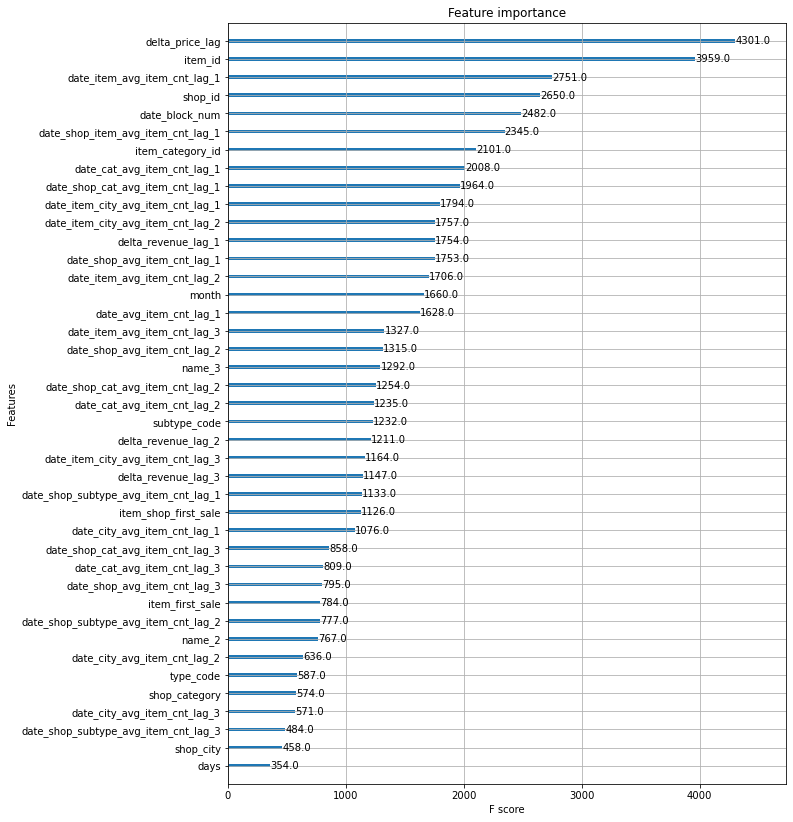

In [113]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))